In [1]:
# MODEL 3: RESNET WITH ADVANCED TECHNIQUES

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [3]:
# Load and split data
df = pd.read_csv("urgent_care_images_master_final.csv")

train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (6084, 2)
Val: (1304, 2)
Test: (1304, 2)


In [4]:
# Setup classes and constants
all_classes = sorted(df['label'].unique())
print("All classes:", all_classes)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
n_classes = len(all_classes)

All classes: ['burn_1and2', 'burn_3rd', 'wound_abrasions', 'wound_bruises', 'wound_diabetic_wounds', 'wound_laceration', 'wound_pressure_wounds', 'wound_venous_wounds']


In [5]:
#  Calculate class weights
class_counts = train_df['label'].value_counts()
print("Class distribution:")
print(class_counts)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weight_dict = {}
for i, class_name in enumerate(all_classes):
    weight_idx = np.where(np.unique(train_df['label']) == class_name)[0][0]
    class_weight_dict[i] = class_weights[weight_idx]

print("Class weights:", class_weight_dict)


Class distribution:
label
burn_1and2               3413
burn_3rd                  902
wound_pressure_wounds     421
wound_venous_wounds       346
wound_diabetic_wounds     324
wound_bruises             255
wound_laceration          249
wound_abrasions           174
Name: count, dtype: int64
Class weights: {0: 0.22282449457954878, 1: 0.8431263858093127, 2: 4.370689655172414, 3: 2.9823529411764707, 4: 2.3472222222222223, 5: 3.0542168674698793, 6: 1.8064133016627077, 7: 2.197976878612717}


In [6]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        ce = -y_true * tf.math.log(y_pred)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_t, 1 - alpha_t)
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        fl = focal_weight * ce
        
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    
    return focal_loss_fixed


In [7]:
#  Create mixup function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    
    return mixed_x, mixed_y

class MixupGenerator:
    def __init__(self, generator, alpha=0.2):
        self.generator = generator
        self.alpha = alpha
    
    def __iter__(self):
        return self
    
    def __next__(self):
        x, y = next(self.generator)
        if self.alpha > 0:
            x, y = mixup_data(x, y, self.alpha)
        return x, y

In [8]:
#Create attention mechanism
def create_attention_block(inputs, channels):
    # Channel attention
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    
    avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
    max_pool = layers.Reshape((1, 1, channels))(max_pool)
    
    avg_pool = layers.Dense(channels // 8, activation='relu')(avg_pool)
    max_pool = layers.Dense(channels // 8, activation='relu')(max_pool)
    
    avg_pool = layers.Dense(channels, activation='sigmoid')(avg_pool)
    max_pool = layers.Dense(channels, activation='sigmoid')(max_pool)
    
    channel_attention = layers.Add()([avg_pool, max_pool])
    attended = layers.Multiply()([inputs, channel_attention])
    
    return attended

In [9]:
#  Create advanced ResNet model
def create_advanced_resnet_model(num_classes):
    # Load pre-trained ResNet50V2
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Get the output from base model
    x = base_model.output
    
    # Add attention mechanism
    x = create_attention_block(x, 2048)
    
    # Global pooling with both average and max
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    
    # Concatenate pooling outputs
    concat = layers.Concatenate()([gap, gmp])
    
    # Dense layers with batch normalization and dropout
    x = layers.Dense(1024, activation='relu')(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

In [10]:
#  Create model
model3, base_model3 = create_advanced_resnet_model(n_classes)

model3.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print("Model 3 created successfully!")
print(f"Total parameters: {model3.count_params():,}")

Model 3 created successfully!
Total parameters: 30,527,240


In [11]:
#  Create advanced data generators
advanced_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    channel_shift_range=0.1,
    fill_mode='nearest'
)

val_datagen3 = ImageDataGenerator(rescale=1./255)

In [12]:
#  Create base generators
train_gen3_base = advanced_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True,
    classes=all_classes
)

val_gen3 = val_datagen3.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False,
    classes=all_classes
)

# Apply mixup to training generator
train_gen3 = MixupGenerator(train_gen3_base, alpha=0.2)

print("Data generators created with mixup!")

Found 6084 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Data generators created with mixup!


In [13]:
#  Phase 1 - Train with frozen base
print("Phase 1: Training with frozen ResNet base...")

callbacks_phase1 = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.3, patience=3, min_lr=1e-7, monitor='val_loss'),
    ModelCheckpoint('resnet_phase1.h5', save_best_only=True, monitor='val_accuracy')
]

EPOCHS_PHASE1 = 15
history3_phase1 = model3.fit(
    train_gen3,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_gen3,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=1
)

print("Phase 1 completed!")

Phase 1: Training with frozen ResNet base...
Epoch 1/15
190/190 [==============================] - 41s 208ms/step - loss: 0.1078 - accuracy: 0.5234 - val_loss: 0.5020 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 2/15
190/190 [==============================] - 39s 207ms/step - loss: 0.0844 - accuracy: 0.6018 - val_loss: 0.2685 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 3/15
190/190 [==============================] - 37s 195ms/step - loss: 0.0662 - accuracy: 0.6041 - val_loss: 0.3196 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 4/15
190/190 [==============================] - 37s 195ms/step - loss: 0.0628 - accuracy: 0.5990 - val_loss: 0.2608 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 5/15
190/190 [==============================] - 37s 194ms/step - loss: 0.0649 - accuracy: 0.6097 - val_loss: 0.2267 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 6/15
190/190 [==============================] - 37s 198ms/step - loss: 0.0573 - accuracy: 0.6173 - val_loss: 0.2162 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 7

In [14]:
#  Phase 2 - Fine-tune with unfrozen layers
print("Phase 2: Fine-tuning...")

# Unfreeze the base model gradually
base_model3.trainable = True

# Fine-tune from the last few blocks
fine_tune_at = len(base_model3.layers) - 30

# Freeze all layers except the last few
for layer in base_model3.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with very low learning rate
model3.compile(
    optimizer=optimizers.Adam(learning_rate=0.00005),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print(f"Fine-tuning from layer: {fine_tune_at}")
print(f"Trainable layers: {sum([layer.trainable for layer in model3.layers])}")

Phase 2: Fine-tuning...
Fine-tuning from layer: 160
Trainable layers: 53


In [15]:
#  Train Phase 2
callbacks_phase2 = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-8, monitor='val_loss'),
    ModelCheckpoint('resnet_phase2.h5', save_best_only=True, monitor='val_accuracy')
]

EPOCHS_PHASE2 = 20
history3_phase2 = model3.fit(
    train_gen3,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_gen3,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 completed!")

Epoch 1/20
190/190 [==============================] - 39s 195ms/step - loss: 0.0584 - accuracy: 0.5960 - val_loss: 0.2654 - val_accuracy: 0.6094 - lr: 5.0000e-05
Epoch 2/20
190/190 [==============================] - 39s 205ms/step - loss: 0.0576 - accuracy: 0.6005 - val_loss: 0.2355 - val_accuracy: 0.6039 - lr: 5.0000e-05
Epoch 3/20
190/190 [==============================] - 37s 198ms/step - loss: 0.0574 - accuracy: 0.5957 - val_loss: 0.2075 - val_accuracy: 0.6117 - lr: 5.0000e-05
Epoch 4/20
190/190 [==============================] - 37s 196ms/step - loss: 0.0597 - accuracy: 0.6097 - val_loss: 0.1946 - val_accuracy: 0.6305 - lr: 5.0000e-05
Epoch 5/20
190/190 [==============================] - 37s 197ms/step - loss: 0.0532 - accuracy: 0.6071 - val_loss: 0.1950 - val_accuracy: 0.6391 - lr: 5.0000e-05
Epoch 6/20
190/190 [==============================] - 36s 193ms/step - loss: 0.0537 - accuracy: 0.6087 - val_loss: 0.1856 - val_accuracy: 0.6359 - lr: 5.0000e-05
Epoch 7/20
190/190 [========

In [16]:
# Evaluate on test set
test_datagen3 = ImageDataGenerator(rescale=1./255)
test_gen3 = test_datagen3.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False,
    classes=all_classes
)

loss3, acc3 = model3.evaluate(test_gen3)
print(f"Model 3 Test Accuracy: {acc3:.4f} ({acc3*100:.1f}%)")

# Save the model
model3.save("advanced_resnet_model.h5")
print("Model 3 saved!")


Found 1304 validated image filenames belonging to 8 classes.
41/41 [==============================] - 2s 39ms/step - loss: 0.2130 - accuracy: 0.6081
Model 3 Test Accuracy: 0.6081 (60.8%)
Model 3 saved!


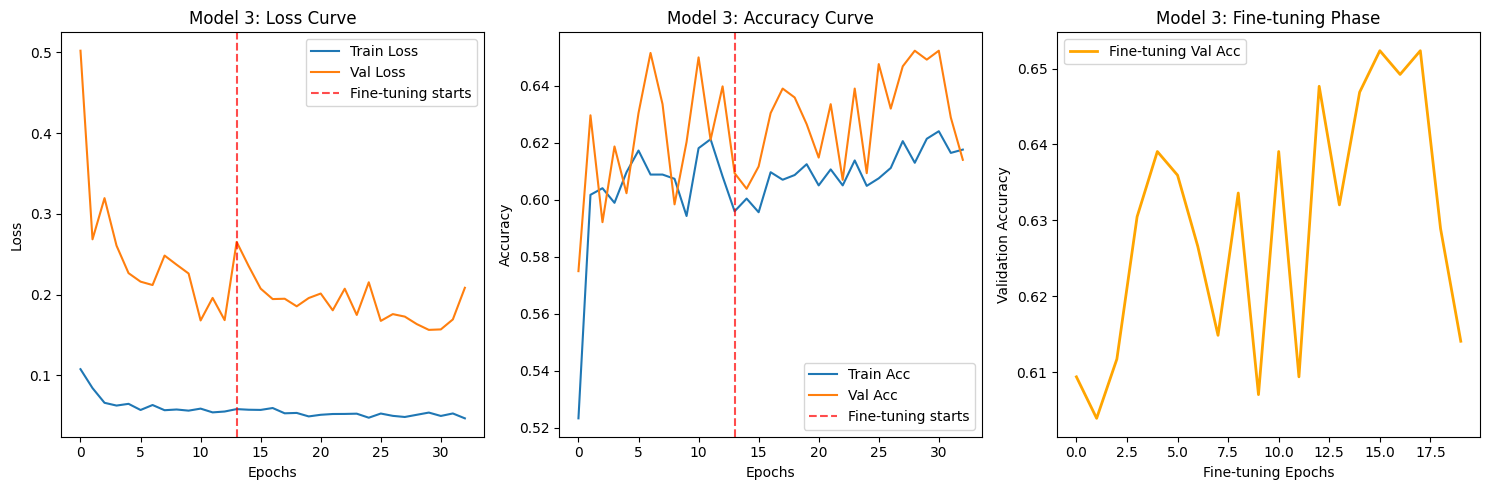

In [17]:
#  Plot training history
plt.figure(figsize=(15, 5))

# Combine histories from both phases
total_epochs_phase1 = len(history3_phase1.history['loss'])
total_epochs_phase2 = len(history3_phase2.history['loss'])

combined_loss = history3_phase1.history['loss'] + history3_phase2.history['loss']
combined_val_loss = history3_phase1.history['val_loss'] + history3_phase2.history['val_loss']
combined_acc = history3_phase1.history['accuracy'] + history3_phase2.history['accuracy']
combined_val_acc = history3_phase1.history['val_accuracy'] + history3_phase2.history['val_accuracy']

epochs_range = range(total_epochs_phase1 + total_epochs_phase2)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, combined_loss, label='Train Loss')
plt.plot(epochs_range, combined_val_loss, label='Val Loss')
plt.axvline(x=total_epochs_phase1, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.title('Model 3: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, combined_acc, label='Train Acc')
plt.plot(epochs_range, combined_val_acc, label='Val Acc')
plt.axvline(x=total_epochs_phase1, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.title('Model 3: Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(total_epochs_phase2), history3_phase2.history['val_accuracy'], 
         label='Fine-tuning Val Acc', color='orange', linewidth=2)
plt.title('Model 3: Fine-tuning Phase')
plt.xlabel('Fine-tuning Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Final results
print("="*60)
print("MODEL 3 RESULTS (Advanced ResNet with Focal Loss & Mixup)")
print("="*60)
print(f"Test Accuracy: {acc3:.4f} ({acc3*100:.1f}%)")
print(f"Improvement over baseline (74.1%): {(acc3-0.741)*100:+.1f}%")
print("\nKey features:")
print("- ResNet50V2 backbone with ImageNet weights")
print("- Attention mechanism")
print("- Focal loss for class imbalance")
print("- Mixup data augmentation")
print("- Two-phase training (frozen + fine-tuning)")
print("- Advanced regularization")

MODEL 3 RESULTS (Advanced ResNet with Focal Loss & Mixup)
Test Accuracy: 0.6081 (60.8%)
Improvement over baseline (74.1%): -13.3%

Key features:
- ResNet50V2 backbone with ImageNet weights
- Attention mechanism
- Focal loss for class imbalance
- Mixup data augmentation
- Two-phase training (frozen + fine-tuning)
- Advanced regularization
